# **Optimization**

In [30]:
# Market으로 Data 바꿈 v
# GMV 1개월 단위로 Rebalancing함 v
"""
download 함수가 yf.download처럼 market 데이터에서 가져오는건데
가끔씩 날짜 정확하게 입력안하면 수익률 계산할 때 오류나는 경우가 있어서
만약에 그 날짜 없으면 가장 최근 이전 날짜에서 가져오게 해야할 것 같음
ㅜㅡㅜ :(:(:( ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ ㄹㅇㅁ람아ㅓㄴ롱마뢍ㄴ
"""
import numpy as np
import cvxpy as cp
import cplex
from tqdm import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf

In [31]:
market_data = pd.read_csv('./new_market.csv')

In [32]:
stocks_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

stocks_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

stocks_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

In [33]:
market_data['pricingDate'] = pd.to_datetime(market_data['pricingDate'])
market_data.set_index('pricingDate', inplace = True)

In [34]:
# yfinance에서 데이터 가져오는 것 대신 S&P market 데이터에서 데이터 가져울 수 있게 함수 만듬
# 원하는 티커(dict에서 가져와도됨), 날짜 넣으면 됨


def download(dict, start_date, end_date):
    data = pd.DataFrame()
    a = pd.DataFrame()
    tickers = list(dict.keys())

    for ticker in tqdm(tickers):
        a = market_data.loc[start_date:end_date, ticker]
        data = pd.concat([data, a], axis=1)

    return data

## **GMV**

In [36]:
gmv_15 = gmv(stocks_15)
gmv_30 = gmv(stocks_30)
gmv_45 = gmv(stocks_45)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 294.11it/s]


Optimal


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 335.19it/s]


Optimal


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 331.49it/s]


Optimal


In [37]:
# 누적 수익률 함수
# bool에 True를 넣으면 gpt gmv opt 데이터로 실행, False이면 GPT로 이미 가져와있는거 실행

def cum_ret_gmv(dic, w_opt, start_date, end_date):  
    
    result = dict(zip(list(dic.keys()), w_opt))
    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

def cum_ret_gpt(dic, start_date, end_date):  

    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(dic))
    cum_ret = (1 + pfo_ret).cumprod()        
        
    return cum_ret

In [38]:
cum_15 = cum_ret_gmv(stocks_15, gmv_15, '2018-05-01', '2023-04-28')
cum_30 = cum_ret_gmv(stocks_30, gmv_30, '2018-05-01', '2023-04-28')
cum_45 = cum_ret_gmv(stocks_45, gmv_45, '2018-05-01', '2023-04-28')

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 323.58it/s]


In [39]:
gpt_15 = cum_ret_gpt(stocks_15, '2018-05-01', '2023-04-28')
gpt_30 = cum_ret_gpt(stocks_30, '2018-05-01', '2023-04-28')
gpt_45 = cum_ret_gpt(stocks_45, '2018-05-01', '2023-04-28')

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 318.96it/s]


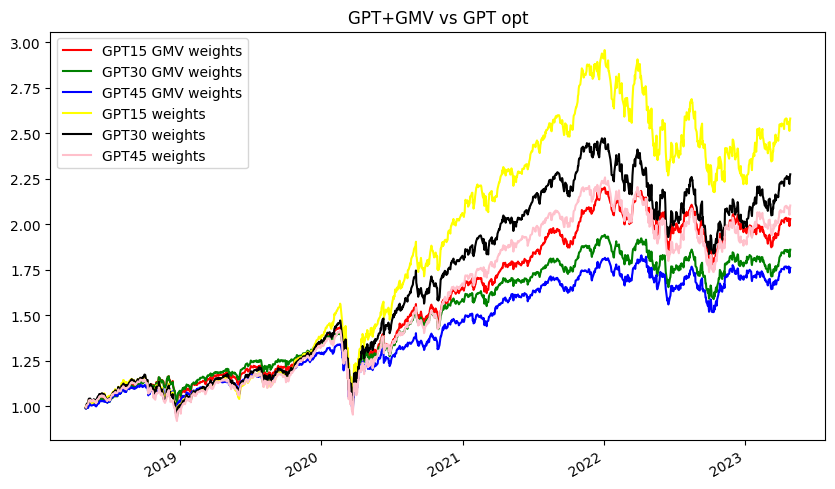

In [40]:
# Log

plt.figure(figsize=(10,6))
plt.title("GPT+GMV vs GPT opt")

cum_15.plot(label='GPT15 GMV weights', color='red')
cum_30.plot(label='GPT30 GMV weights', color='green')
cum_45.plot(label='GPT45 GMV weights', color='blue')
gpt_15.plot(label='GPT15 weights', color='yellow')
gpt_30.plot(label='GPT30 weights', color='black')
gpt_45.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

## **Max Sharpe Ratio**

In [41]:
def max_sharpe(dict):
    df = download(dict, "2018-05-01", "2023-04-30")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    ef = EfficientFrontier(mu, S)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets

    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)
    
    ef.add_constraint(lambda w: w.sum() == 1)

    w_opt = ef.max_sharpe() # Max Sharpe ratio가 되는 weights 찾기

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean

In [42]:
msp_15 = max_sharpe(stocks_15)
msp_30 = max_sharpe(stocks_30)
msp_45 = max_sharpe(stocks_45)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 329.31it/s]



Expected annual return: 24.6%
Annual volatility: 26.7%
Sharpe Ratio: 0.85

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 149.69it/s]



Expected annual return: 17.7%
Annual volatility: 22.0%
Sharpe Ratio: 0.72

가장 큰 가중치를 가진 자산: MRK
가장 큰 가중치: 0.06667


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 341.14it/s]



Expected annual return: 17.1%
Annual volatility: 21.4%
Sharpe Ratio: 0.71

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [50]:
def max_sharpe_cum_ret(dic, result, start_date, end_date):
    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

msf_15 = max_sharpe_cum_ret(stocks_15, msp_15, '2018-05-01', '2023-04-28')
msf_30 = max_sharpe_cum_ret(stocks_30, msp_30, '2018-05-01', '2023-04-28')
msf_45 = max_sharpe_cum_ret(stocks_45, msp_45, '2018-05-01', '2023-04-28')

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 329.10it/s]


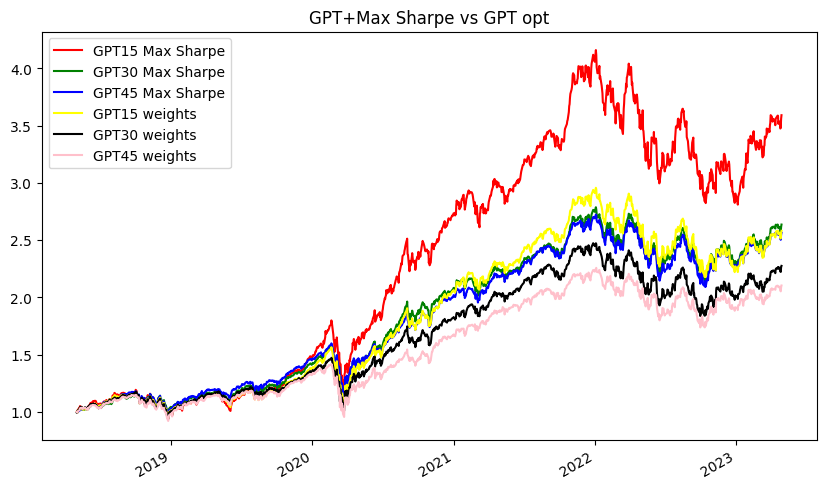

In [51]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Sharpe vs GPT opt")

msf_15.plot(label='GPT15 Max Sharpe', color='red')
msf_30.plot(label='GPT30 Max Sharpe', color='green')
msf_45.plot(label='GPT45 Max Sharpe', color='blue')
gpt_15.plot(label='GPT15 weights', color='yellow')
gpt_30.plot(label='GPT30 weights', color='black')
gpt_45.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

## **Max Expected Returns**

In [52]:
def max_return(dict):
    df = download(dict, "2018-05-01", "2023-04-30")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    ef = EfficientFrontier(mu, S, solver='ECOS')
    ef.add_constraint(lambda x: x.sum() == 1,)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets
    
    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)

    w_opt = ef._max_return()

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean

In [53]:
max_ret_15 = max_return(stocks_15)
max_ret_30 = max_return(stocks_30)
max_ret_45 = max_return(stocks_45)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 261.77it/s]



Expected annual return: 24.7%
Annual volatility: 26.7%
Sharpe Ratio: 0.85

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 337.95it/s]



Expected annual return: 18.2%
Annual volatility: 23.5%
Sharpe Ratio: 0.69

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 342.82it/s]



Expected annual return: 17.3%
Annual volatility: 22.1%
Sharpe Ratio: 0.70

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [54]:
def max_sharpe_cum_ret(dic, result, start_date, end_date):
    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

max_15 = max_sharpe_cum_ret(stocks_15, max_ret_15, '2018-05-01', '2023-04-30')
max_30 = max_sharpe_cum_ret(stocks_30, max_ret_30, '2018-05-01', '2023-04-30')
max_45 = max_sharpe_cum_ret(stocks_45, max_ret_45, '2018-05-01', '2023-04-30')

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 331.10it/s]


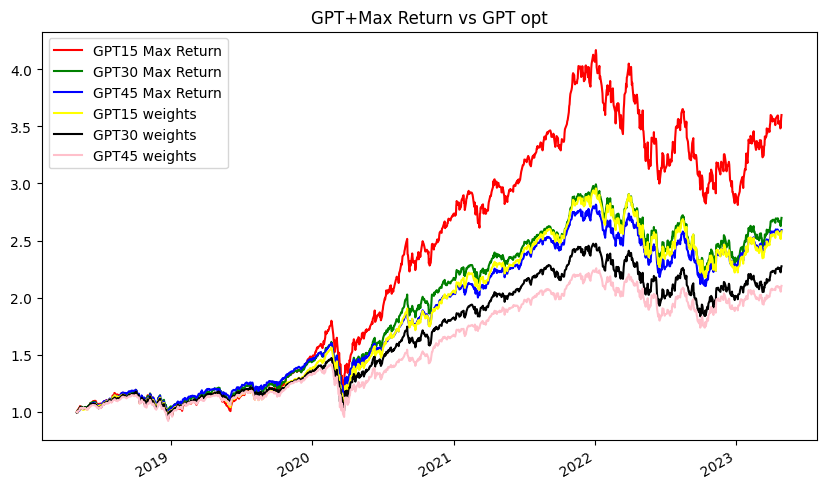

In [55]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Return vs GPT opt")

max_15.plot(label='GPT15 Max Return', color='red')
max_30.plot(label='GPT30 Max Return', color='green')
max_45.plot(label='GPT45 Max Return', color='blue')
gpt_15.plot(label='GPT15 weights', color='yellow')
gpt_30.plot(label='GPT30 weights', color='black')
gpt_45.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

## **Rebalancing**

In [65]:
def init_opt(dict, start_date, end_date): # 5개년 Optimization

    data = download(dict, start_date, end_date)
    
    ret = data.pct_change().dropna()
    
    num_assets = data.shape[1] # 종목 개수가 나와야함
    weights = cp.Variable((num_assets,1)) # 종목 개수랑 같아야함
    cov_mat = np.cov(ret.values.T) # 개별 종목 별 기대수익률을 구해서 Covariance Matrix를 만듬
    
    obj = cp.Minimize(cp.quad_form(weights, cov_mat)) # 목적식 설정

    len_stock = len(dict.keys())
    
    # weights >= 0 
    const = [cp.sum(weights) == 1,
             cp.min(weights) >= 1/len_stock * 0.5,
             cp.max(weights) <= 1/len_stock * 2] # 제약식 설정, 공매도 원하면 위에 주석 가져다 옆으로 복붙하면됨
    
    problem = cp.Problem(obj, const) # 문제 정의
    problem.solve(verbose=False, solver=cp.CPLEX) # 문제 풀기
    
    if problem.status == "optimal":
        w_opt = np.array(weights.value).flatten()
        print("Optimal")
        # print(gmv_weights.value[:5])
        
        # print(max(gmv_weights.value)) # 가장 큰 weight를 보고싶으면 이거 주석 해제
    else:
        print("It isn't optimal")

    return w_opt

In [66]:
def init_ret(dic, w_opt, start_date, end_date):  
    
    result = dict(zip(list(dic.keys()), w_opt))
    data = download(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

In [71]:
init_start = '2018-05-01'
init_start = datetime.strptime(init_start, '%Y-%m-%d')
init_end = '2023-05-01'

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 241.20it/s]


Optimal


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.95it/s]


In [ ]:
opt_0 = init_opt(stocks_15, init_start, init_end) # rebalance 0
ret_0 = init_ret(stocks_15, init_15, init_end, init_end + 1)

opt_1 = init_opt(stocks_15, init_start, init_end + 1) # rebalance 1
ret_1 = init_ret(stocks_15, init_15, init_end + 1, init_end + 2)

opt_2 = init_opt(stocks_15, init_start, init_end + 2) # rebalance 2
ret_2 = init_ret(stocks_15, init_15, init_end + 2, init_end + 3)

opt_3 = init_opt(stocks_15, init_start, init_end + 3) # rebalance 3
ret_3 = init_ret(stocks_15, init_15, init_end + 3, init_end + 4)

opt_4 = init_opt(stocks_15, init_start, init_end + 4) # rebalance 4
ret_4 = init_ret(stocks_15, init_15, init_end + 4, init_end + 5)

opt_5 = init_opt(stocks_15, init_start, init_end + 5) # rebalance 5
ret_5 = init_ret(stocks_15, init_15, init_end + 5, init_end + 6)

# cum_ret을 다 합치면됨
# for문 만들고 함수화 하면 될듯, 한 달후 날짜만 가져오는 방법만 하며 됨 생각보다 쉽진 않네